In [96]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.regularizers import l2
import wandb
from wandb.keras import WandbCallback
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Inicializar un nuevo experimento en Weights & Biases
#wandb.init(project='LSTM training' )



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇██▇▆▆▇▆▆▅▅▄▅▅▅▄▄▅▄▄▃▄▅▃▅▃▂▂▂▃▃▂▂▁▃▁▁▃▃▁
val_loss,▆▁▃▃▄▇▂▃▄▄▅▄▄▇▅▆▆▆▅▄▄▄▆▆▅▅▆▅▆▆▄▅█▇▆█▆▆▇▅
best_epoch,1
best_val_loss,0.01203
epoch,49
loss,0.01189
val_loss,0.01336


In [94]:
wandbcallback = WandbCallback()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [112]:

station_columns = [
    'station_Barcelona (Ciutadella)', 'station_Barcelona (Eixample)',
    'station_Barcelona (Gràcia - Sant Gervasi)', 'station_Barcelona (Observatori Fabra)',
    'station_Barcelona (Palau Reial)', 'station_Barcelona (Parc Vall Hebron)',
    'station_Barcelona (Poblenou)', 'station_Barcelona (Sants)'
]

In [121]:
# Cargar datos
data = pd.read_csv('imputed_data.csv', parse_dates=['Date_time'], index_col='Date_time')

# Supongamos que quieres predecir PM10, usaremos NO, NO2, NOX, O3 como features
#data=data[data['station_Barcelona (Eixample)'] == 1]
features = data[ station_columns]
target = data['NO2']

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1,1))

# Crear secuencias para la entrada en LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5
X, y = create_dataset(features_scaled, target_scaled, time_steps)


In [115]:
print(target.max())

109.3913043478261


In [122]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2]))))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
#model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


In [48]:
#VA FATAL
# model = Sequential()
# # Primera capa LSTM con regularización L2 y retorno de secuencias para apilar otra capa LSTM
# model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.2))  # Añadir dropout para reducir el sobreajuste

# # Segunda capa LSTM
# model.add(LSTM(50, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.2))  # Añadir dropout para reducir el sobreajuste

# # Capa de salida
# model.add(Dense(1))

# # Compilación del modelo
# model.compile(optimizer='adam', loss='mean_squared_error')

In [123]:
# Dividir los datos en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1, shuffle=False, callbacks=[wandbcallback])


Epoch 1/100
731/731 [==============================] - 9s 8ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1120
Epoch 2/100
731/731 [==============================] - 5s 7ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 3/100
731/731 [==============================] - 6s 8ms/step - loss: 0.0116 - root_mean_squared_error: 0.1075 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 4/100
731/731 [==============================] - 6s 8ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 5/100
731/731 [==============================] - 6s 9ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 6/100
731/731 [==============================] - 7s 9ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0125 

In [124]:
# Hacer predicciones
y_pred = model.predict(X_test)

# Desnormalizar los datos si es necesario y evaluar el modelo
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Calcular métricas de rendimiento, por ejemplo, RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('RMSE: %.3f' % rmse)


92/92 [==============================] - 1s 4ms/step
RMSE: 11.244


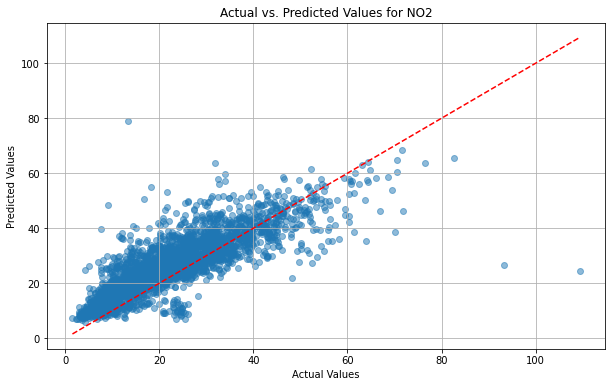

In [119]:

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Diagonal line for reference
plt.title(f'Actual vs. Predicted Values for NO2')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
#plt.savefig(f"plot_varma_{station}.png")
plt.show()

In [85]:
import kerastuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   activation='relu',
                   input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Número de configuraciones de parámetros para probar
    executions_per_trial=3,  # Número de modelos que se deben entrenar y evaluar por prueba
    directory='my_dir',
    project_name='keras_tuner_lstm')

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]


Trial 5 Complete [00h 00m 27s]
val_loss: 0.011791128354767958

Best val_loss So Far: 0.011791128354767958
Total elapsed time: 00h 02m 29s


In [90]:
best_hp = tuner.get_best_hyperparameters()[0]

# Acceder a un hiperparámetro específico, por ejemplo, la tasa de aprendizaje
best_learning_rate = best_hp.get('learning_rate')
print("Mejor tasa de aprendizaje: ", best_learning_rate)

# Puedes reconstruir el modelo con estos hiperparámetros si es necesario
model = build_model(best_hp)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))


Mejor tasa de aprendizaje:  0.0076493524681733455
Epoch 1/100
92/92 [==============================] - 4s 11ms/step - loss: 0.0249 - val_loss: 0.0131
Epoch 2/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0195 - val_loss: 0.0156
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0192 - val_loss: 0.0130
Epoch 4/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0186 - val_loss: 0.0167
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0182 - val_loss: 0.0125
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0173 - val_loss: 0.0147
Epoch 7/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0171 - val_loss: 0.0146
Epoch 8/100
92/92 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0133
Epoch 9/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0175 - val_loss: 0.0119
Epoch 10/100
92/92 [==============================] - 1s 8